Loading checkpoint: /Users/olgashalashova/CREStereo/models/crestereo_eth3d.pth


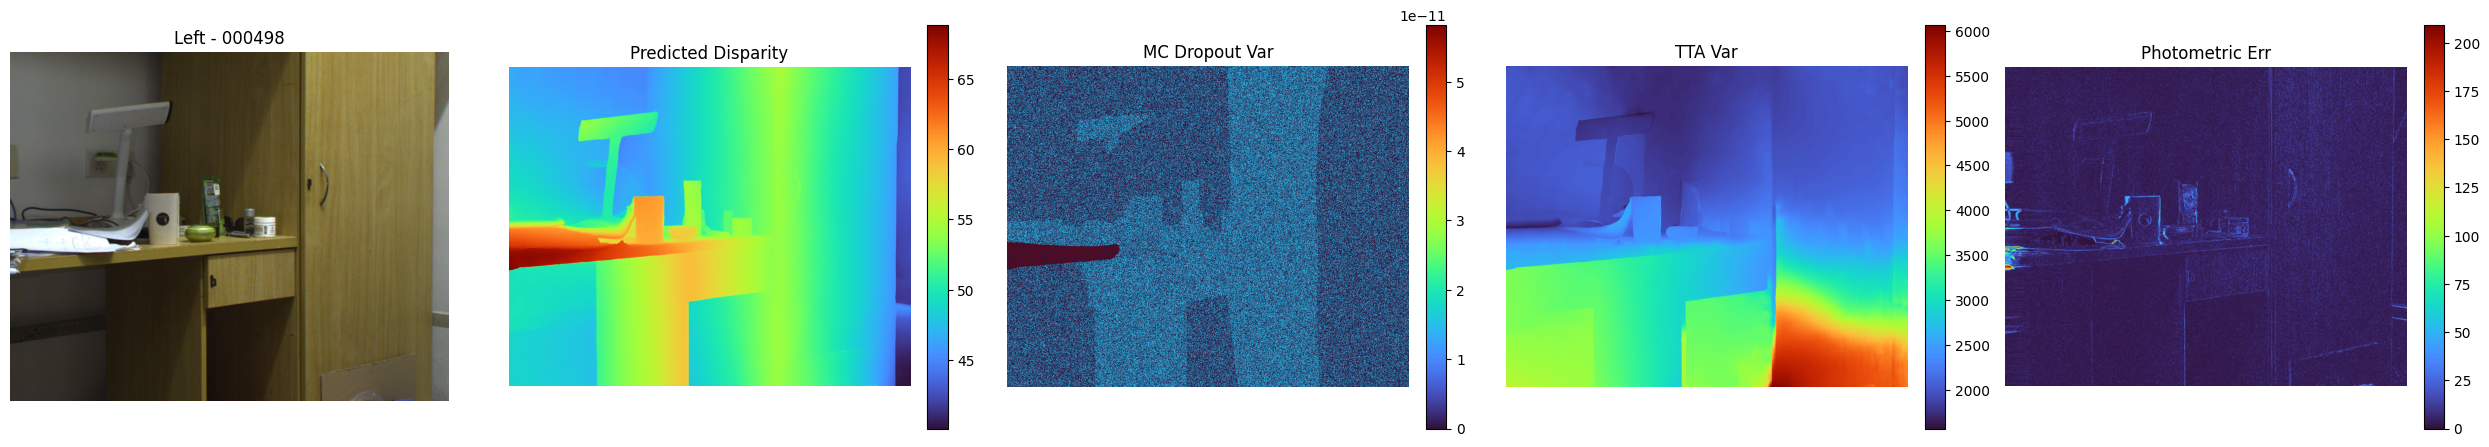

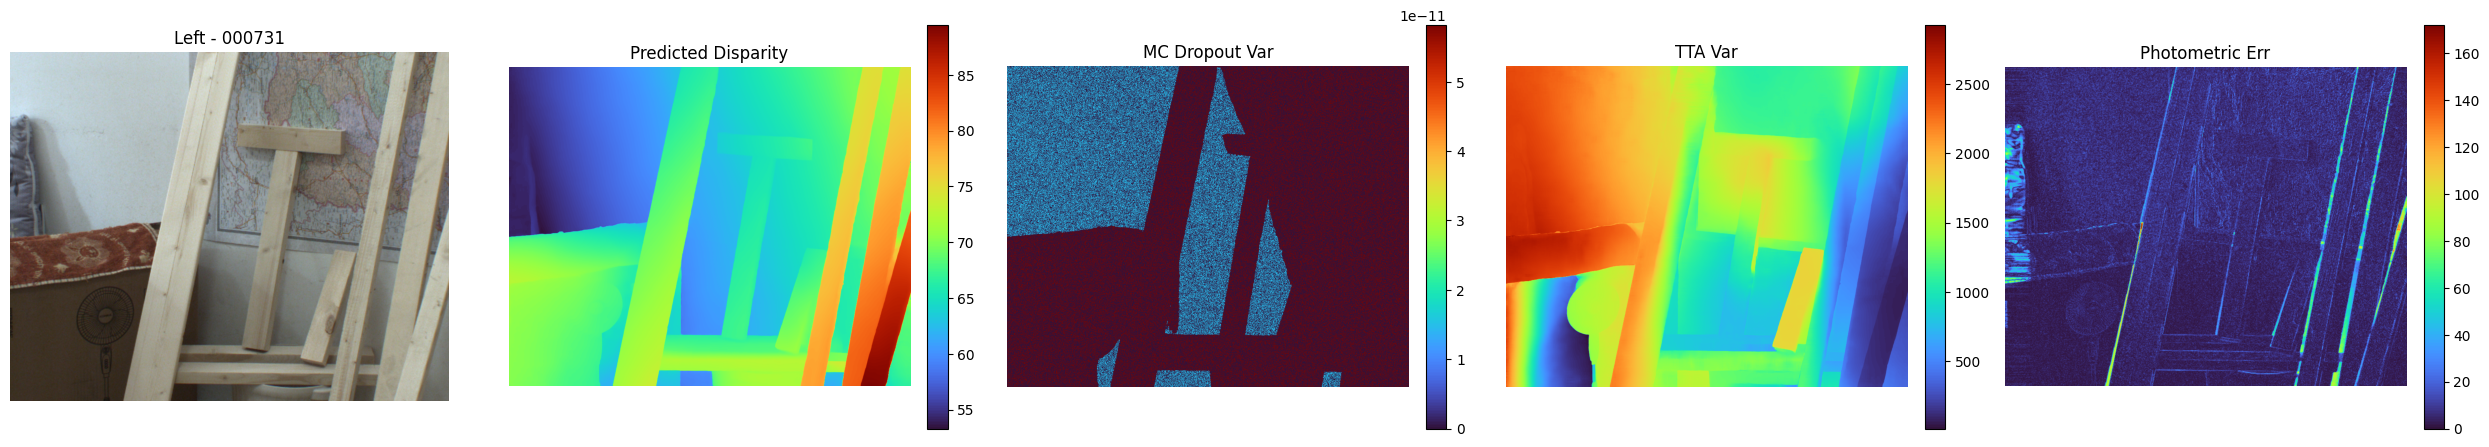

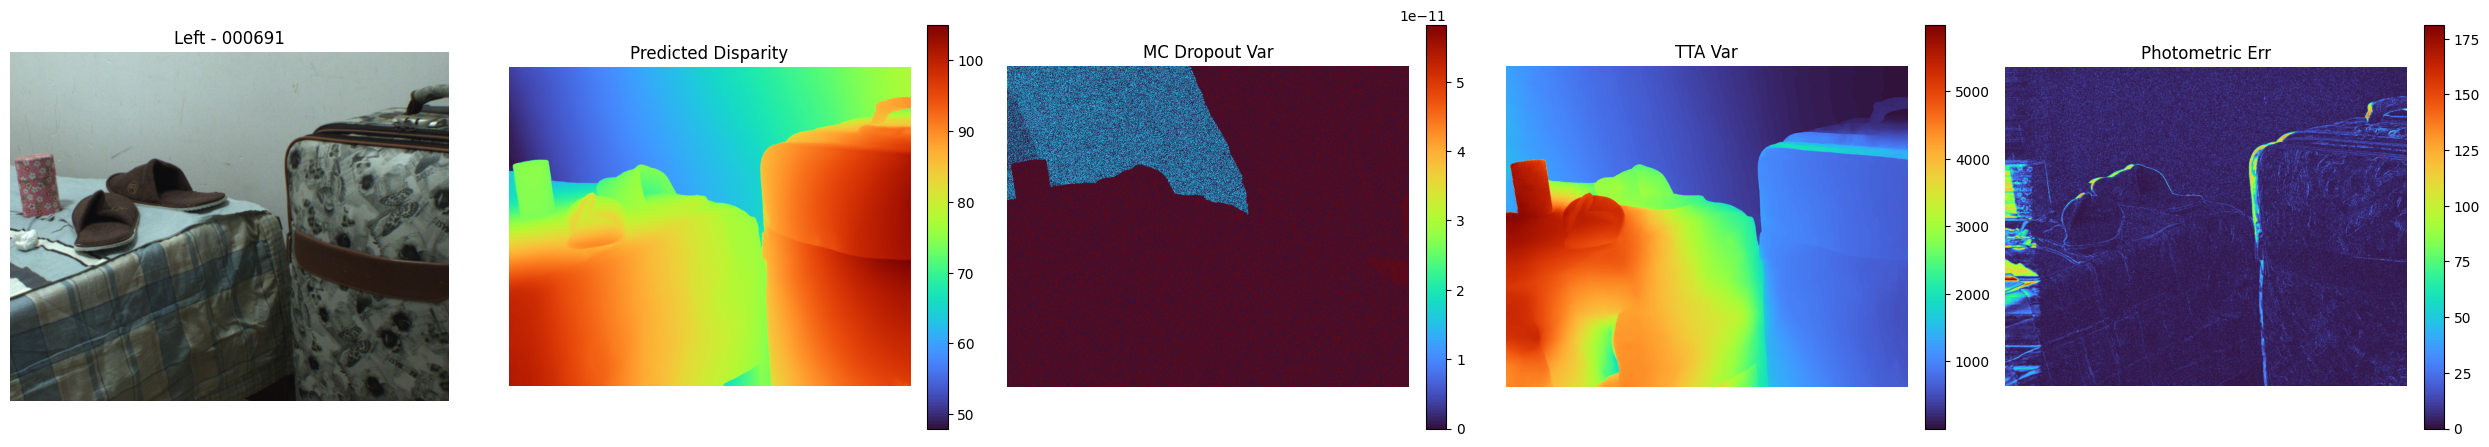

In [ ]:
import os
import sys
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt



DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
REPO_CANDIDATE_NAMES = ("CREStereo-Pytorch", "CREStereo")

def ensure_crestereo_on_path(max_depth: int = 6) -> Path:
    """Locate a local CREStereo PyTorch repo and add it to sys.path."""
    roots = []
    current = Path.cwd().resolve()
    for _ in range(max_depth + 1):
        roots.append(current)
        current = current.parent
    roots.append(Path.home().resolve())
    seen = set()
    for root in roots:
        if root in seen:
            continue
        seen.add(root)
        for name in REPO_CANDIDATE_NAMES:
            candidate = (root / name).resolve()
            nets_file = candidate / "nets" / "crestereo.py"
            if nets_file.is_file():
                candidate_str = str(candidate)
                if candidate_str not in sys.path:
                    sys.path.insert(0, candidate_str)
                return candidate
    raise ModuleNotFoundError("Не удалось найти локальную копию CREStereo-Pytorch.")

def find_crestereo_checkpoint(repo_root: Path) -> Path:
    """Try to locate the ETH3D checkpoint near the repo."""
    repo_root = repo_root.resolve()
    candidates = [repo_root / "models" / "crestereo_eth3d.pth"]
    neighbours = [
        repo_root.parent / "CREStereo",
        repo_root.parent / "CREStereo-Pytorch",
        Path.home() / "CREStereo",
        Path.home() / "CREStereo-Pytorch",
        Path.cwd().resolve().parent / "CREStereo",
        Path.cwd().resolve().parent / "CREStereo-Pytorch",
    ]
    seen = set()
    for base in neighbours:
        if base is None:
            continue
        try:
            base = base.resolve()
        except FileNotFoundError:
            continue
        if base in seen:
            continue
        seen.add(base)
        candidates.append(base / "models" / "crestereo_eth3d.pth")
    checked = set()
    for path in candidates:
        try:
            resolved = path.resolve()
        except FileNotFoundError:
            continue
        if resolved in checked:
            continue
        checked.add(resolved)
        if resolved.is_file():
            return resolved
    raise FileNotFoundError("Не найден файл весов crestereo_eth3d.pth. Скачайте его и поместите в папку models внутри репозитория.")

def load_image_tensor(path: Path, device: str) -> torch.Tensor:
    arr = np.array(Image.open(path).convert("RGB"), dtype=np.uint8)
    tensor = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).float()
    return tensor.to(device)

def pad_to_multiple(tensor: torch.Tensor, multiple: int = 8):
    _, _, h, w = tensor.shape
    pad_h = (-h) % multiple
    pad_w = (-w) % multiple
    if pad_h or pad_w:
        tensor = F.pad(tensor, (0, pad_w, 0, pad_h), mode="replicate")
    return tensor, pad_h, pad_w

# загрузка модели
crestereo_root = ensure_crestereo_on_path()
from nets import Model
ckpt_path = find_crestereo_checkpoint(crestereo_root)
print(f"Loading checkpoint: {ckpt_path}")

model = Model(max_disp=256, mixed_precision=False, test_mode=True)
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model = model.to(DEVICE).eval()



def confidence_mc_dropout(model, left, right, iters=20, n_samples=8):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            flow = model(left, right, iters=iters)
            disp = flow[:, 0, :, :].detach().cpu().numpy().squeeze(0)  # squeeze добавлен
            preds.append(disp)
    model.eval()
    preds = np.stack(preds, axis=0)  # (n_samples, H, W)
    return preds.mean(axis=0), preds.var(axis=0)


def confidence_tta(model, left, right, iters=20, n_samples=6):
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            if np.random.rand() > 0.5:
                left_aug = torch.flip(left, dims=[-1])
                right_aug = torch.flip(right, dims=[-1])
                flow = model(left_aug, right_aug, iters=iters)
                disp = torch.flip(flow[:, 0, :, :], dims=[-1]).cpu().numpy().squeeze(0)
            else:
                flow = model(left, right, iters=iters)
                disp = flow[:, 0, :, :].cpu().numpy().squeeze(0)
            preds.append(disp)
    preds = np.stack(preds, axis=0)
    return preds.mean(axis=0), preds.var(axis=0)


def confidence_photometric(left_img, right_img, disp_map):
    h, w = disp_map.shape
    coords_x, coords_y = np.meshgrid(np.arange(w), np.arange(h))
    coords_x_warped = (coords_x - disp_map).clip(0, w - 1).astype(int)
    warped_right = right_img[coords_y, coords_x_warped]
    error = np.abs(left_img.astype(np.float32) - warped_right.astype(np.float32)).mean(axis=2)
    return error

def visualize_confidences(left_img, pred_disp, conf_maps, sid=None, colormap="turbo"):
    n_confs = len(conf_maps)
    fig, axs = plt.subplots(1, 2 + n_confs, figsize=(5 * (2 + n_confs), 5))

    # Левое изображение
    axs[0].imshow(left_img)
    axs[0].set_title(f"Left - {sid}")
    axs[0].axis("off")

    # Предсказанная диспарити
    im_disp = axs[1].imshow(pred_disp, cmap=colormap)
    axs[1].set_title("Predicted Disparity")
    axs[1].axis("off")
    fig.colorbar(im_disp, ax=axs[1], fraction=0.046, pad=0.04)

    # Карты уверенности
    for i, (name, conf) in enumerate(conf_maps.items(), start=2):
        im = axs[i].imshow(conf, cmap=colormap)
        axs[i].set_title(name)
        axs[i].axis("off")
        fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()




DATA_ROOT = Path("..") / "data" / "instereo2k_sample"
all_ids = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
scene_ids = random.sample(all_ids, k=3)  # возьмем 3 случайные сцены

for sid in scene_ids:
    left_path = DATA_ROOT / sid / "left.png"
    right_path = DATA_ROOT / sid / "right.png"

    left_tensor = load_image_tensor(left_path, DEVICE)
    right_tensor = load_image_tensor(right_path, DEVICE)
    left_tensor, pad_h, pad_w = pad_to_multiple(left_tensor, multiple=8)
    right_tensor, _, _ = pad_to_multiple(right_tensor, multiple=8)

    # базовое предсказание
    with torch.inference_mode():
        left_half = F.interpolate(left_tensor, scale_factor=0.5, mode="bilinear", align_corners=True)
        right_half = F.interpolate(right_tensor, scale_factor=0.5, mode="bilinear", align_corners=True)
        flow_coarse = model(left_half, right_half, iters=20)
        flow = model(left_tensor, right_tensor, flow_init=flow_coarse, iters=20)

    pred_disp = flow[:, 0, :, :].squeeze(0).detach().cpu().numpy()
    if pad_h or pad_w:
        pred_disp = pred_disp[: pred_disp.shape[0] - pad_h if pad_h else pred_disp.shape[0],
                              : pred_disp.shape[1] - pad_w if pad_w else pred_disp.shape[1]]

    # confidence карты
    mean_mc, var_mc = confidence_mc_dropout(model, left_tensor, right_tensor, n_samples=6)
    mean_tta, var_tta = confidence_tta(model, left_tensor, right_tensor, n_samples=4)
    left_np = np.array(Image.open(left_path).convert("RGB"))
    right_np = np.array(Image.open(right_path).convert("RGB"))
    photo_err = confidence_photometric(left_np, right_np, pred_disp)

    # визуализация
    visualize_confidences(
        Image.open(left_path).convert("RGB"),
        pred_disp,
        {
            "MC Dropout Var": var_mc,
            "TTA Var": var_tta,
            "Photometric Err": photo_err,
        },
        sid=sid
    )
